In [52]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.stats import skew, kurtosis, shapiro
import dill

Data is Delhi daily electricity usage in MWh from Jan 2019-Dec 2023

In [4]:
path = r"D:\Full Stack\Forcast\backend\forcastback\api\Year Data.xlsx"

# load the excel into a dataframe
data = pd.read_excel(path, parse_dates=["Date"])

# parsing dates
data["date"] = data["Date"].dt.date

# renaming energy
data["energy"] = data["Energy"]

# Keep only the "Date" and "Energy" columns, drop any others
data = data[["date", "energy"]]

# Set the "Date" column as the index
data.set_index("date", inplace=True)

# Set the index frequency to daily
data = data.asfreq("D")

# Display the DataFrame information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1908 entries, 2019-01-01 to 2024-03-22
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  1908 non-null   float64
dtypes: float64(1)
memory usage: 29.8 KB


In [5]:
data[:5]

,energy
date,
2019-01-01,4472.0
2019-01-02,4228.0
2019-01-03,4331.0
2019-01-04,4461.0
2019-01-05,4170.0


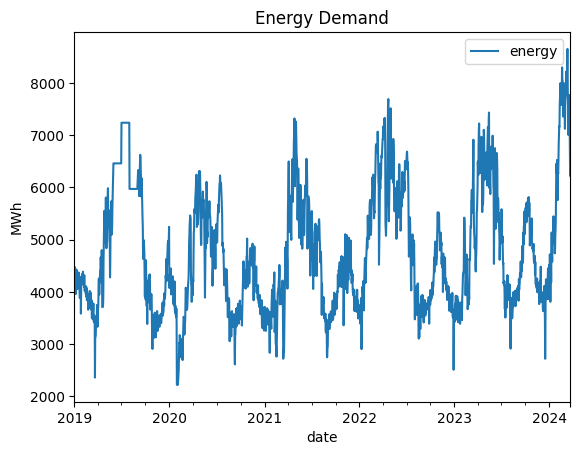

In [6]:
data.plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

In [7]:
len(pd.date_range(start="2019-01-01", end="2023-12-31"))

1826

No missing values, and 4 years of data to enjoy :)

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\419502200.py:7: FutureWarning: The provided callable <function mean at 0x0000021D62656340> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\419502200.py:7: FutureWarning: The provided callable <function std at 0x0000021D62656480> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\419502200.py:8: FutureWarning: The provided callable <function mean at 0x0000021D62656340> is currently using Rolling.mean. In a future version of pandas, the provided callable 

<Figure size 2000x1600 with 0 Axes>

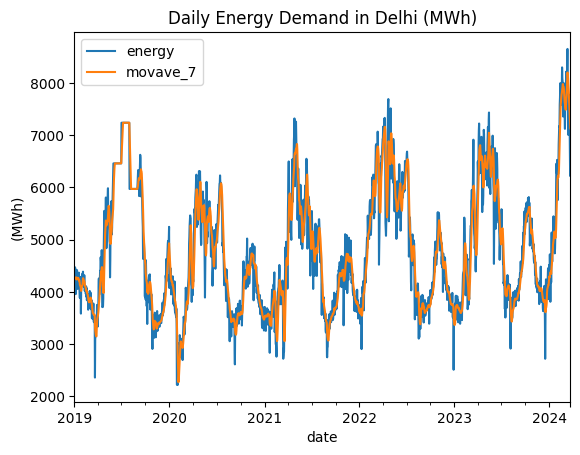

In [8]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.isocalendar().week
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand in Delhi (MWh)")
plt.ylabel("(MWh)")
plt.show()

# EDA: Exploratory Data Analysis
- Target Analysis
- Seasonality and Trend

The goal is to graphically characterize time series data, withouth relying on any (almost) any statistical method like decomposing.

## Target Analysis: Normality

In [9]:
mean = np.mean(data.energy.values)
std = np.std(data.energy.values)
skew = skew(data.energy.values)
ex_kurt = kurtosis(data.energy)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.6235931303224921 
Kurtosis: 2.6414878737020735


- Negative Skewness: Data distribution is not completelly simetric and has a left tail
- Kurtosis below 3: It means that tails are slightly thinner than in a Normal distribution. It is said that the distribution is platykurtic and the chance of finding extre values is lower than in a normal distribution.

In [10]:
def shapiro_test(data, alpha=0.05):
    stat, pval = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))

shapiro_test(data.energy, alpha=0.05)

H0: Data was drawn from a Normal Ditribution
pval 2.074842268678426e-24 is lower than significance level: 0.05, therefore null hypothesis is rejected


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\16411889.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\16411889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.energy)


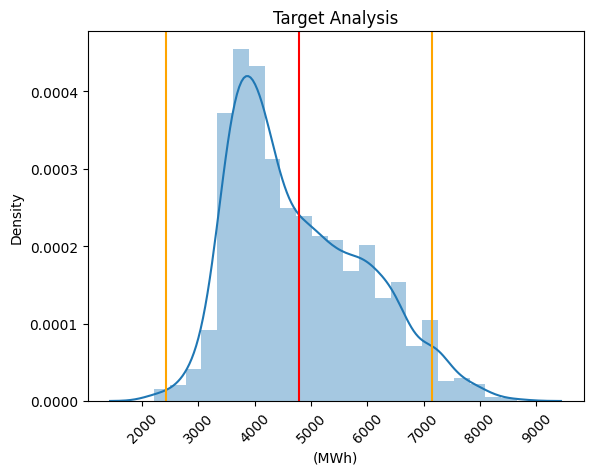

In [11]:
sns.distplot(data.energy)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

Broadly speaking, data does not look like a normal distribution, because it has a small left tail and the chance of observing extreme values is smaller, comparing to normally distributed data

## Volatility Analysis

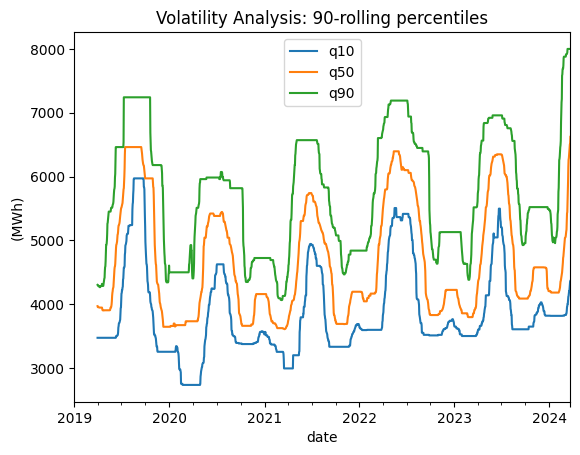

In [12]:
# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=90)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

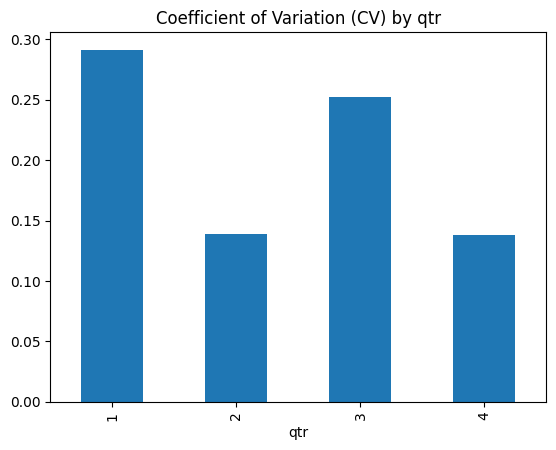

In [13]:
data.groupby("qtr")["energy"].std().divide(data.groupby("qtr")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by qtr")
plt.show()

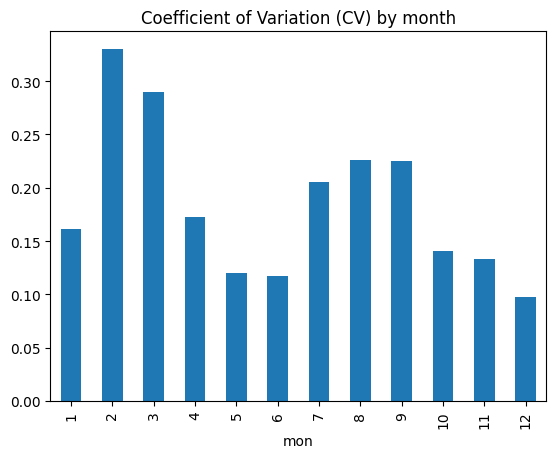

In [14]:
data.groupby("mon")["energy"].std().divide(data.groupby("mon")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

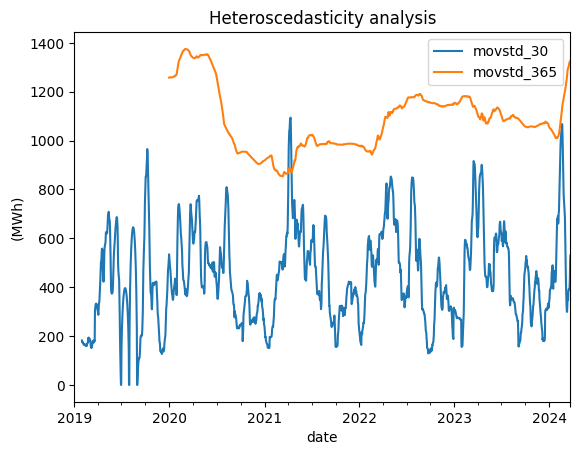

In [15]:
data[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

In the short term (quaterly and monthly) volatility is changeable, but in the long term (year window) it is quite stable, therefore, candidate predictors will have to deal with seasonal pattern in variance.

### Time Series Analysis: Seasonality and Trend

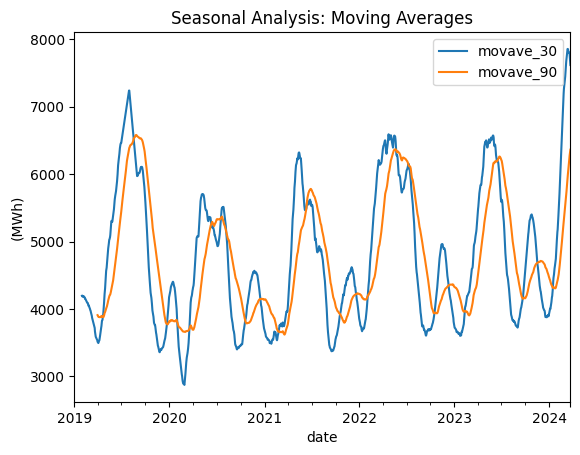

In [16]:
data[["movave_30", "movave_90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

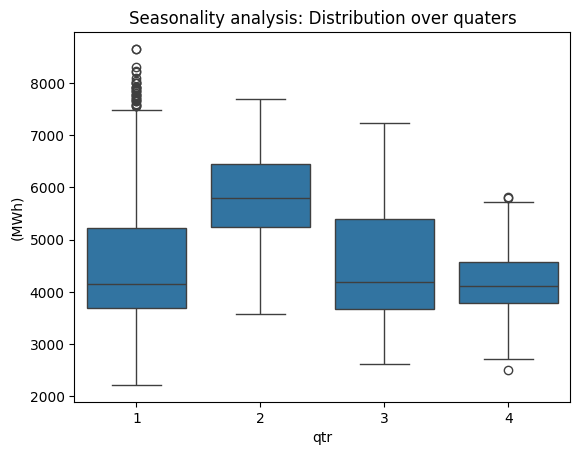

In [17]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

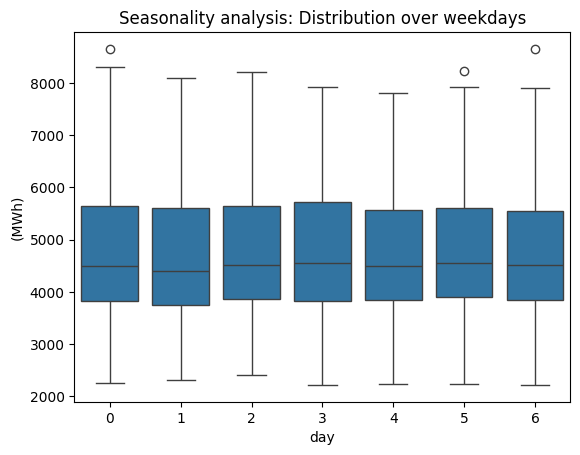

In [18]:
sns.boxplot(data=data, x="day", y="energy")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

As expected, major quaterly trends

In [19]:
data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
data_mon["ix"] = range(0, len(data_mon))
data_mon[:5]

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\3895441439.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\3895441439.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_mon = data.energy.resample("M").agg(sum).to_frame("energy")


,energy,ix
date,,
2019-01-31,130082.0,0
2019-02-28,112208.0,1
2019-03-31,109413.0,2
2019-04-30,131248.0,3
2019-05-31,168110.0,4


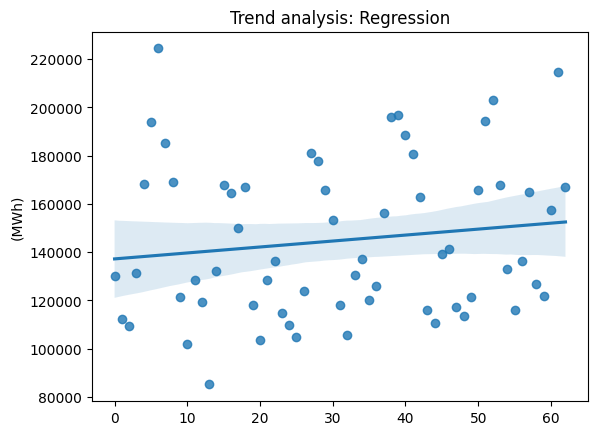

In [20]:
sns.regplot(data=data_mon,x="ix", y="energy")
plt.title("Trend analysis: Regression")
plt.ylabel("(MWh)")
plt.xlabel("")
plt.show()

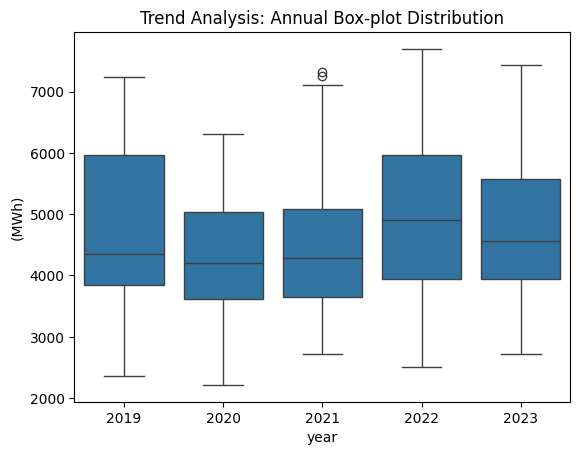

In [21]:
sns.boxplot(data=data["2019":"2023"], x="year", y="energy")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()

There is a positive linear (or sligthly damped) trend in energy demand, beacause of a steady economic grownth due to recession recovery.

# Feature Engineering
The challenge now is to create some features in a very automated way that can deal with seasonality, trend and changes in volatility

Data is standardized in order to allow application of models that are sensitive to scale, like neural networks or svm. Remember that distribution shape is maintained, it only changes first and second momentum (mean and standard deviation)

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1426062513.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["target"])


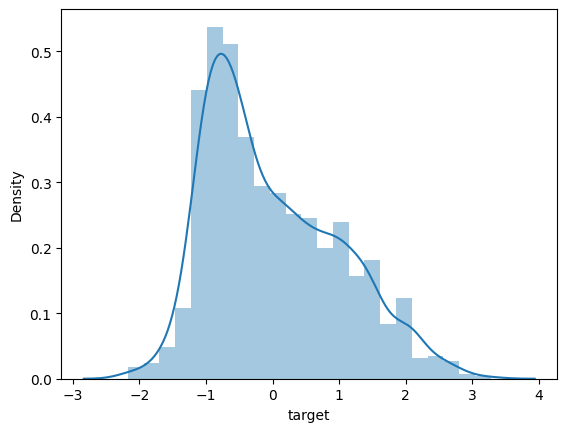

In [22]:
data["target"] = data.energy.add(-mean).div(std)
sns.distplot(data["target"])
plt.show()

In [23]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))

for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")


for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))

months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\2553838581.py:19: FutureWarning: The provided callable <function mean at 0x0000021D62656340> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\2553838581.py:19: FutureWarning: The provided callable <function std at 0x0000021D62656480> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\sidra\AppData\Local\Temp\ipykernel_220

In [24]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

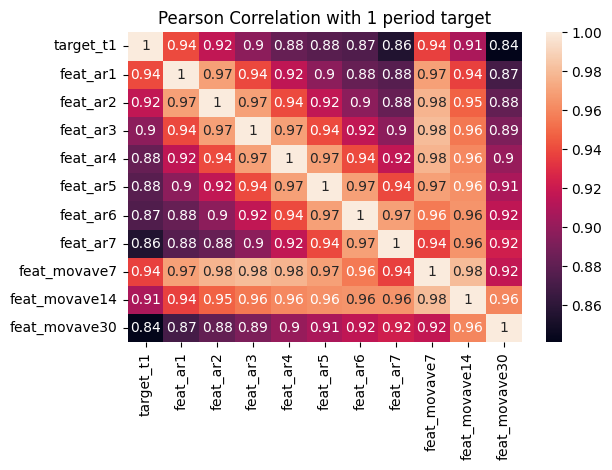

In [25]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

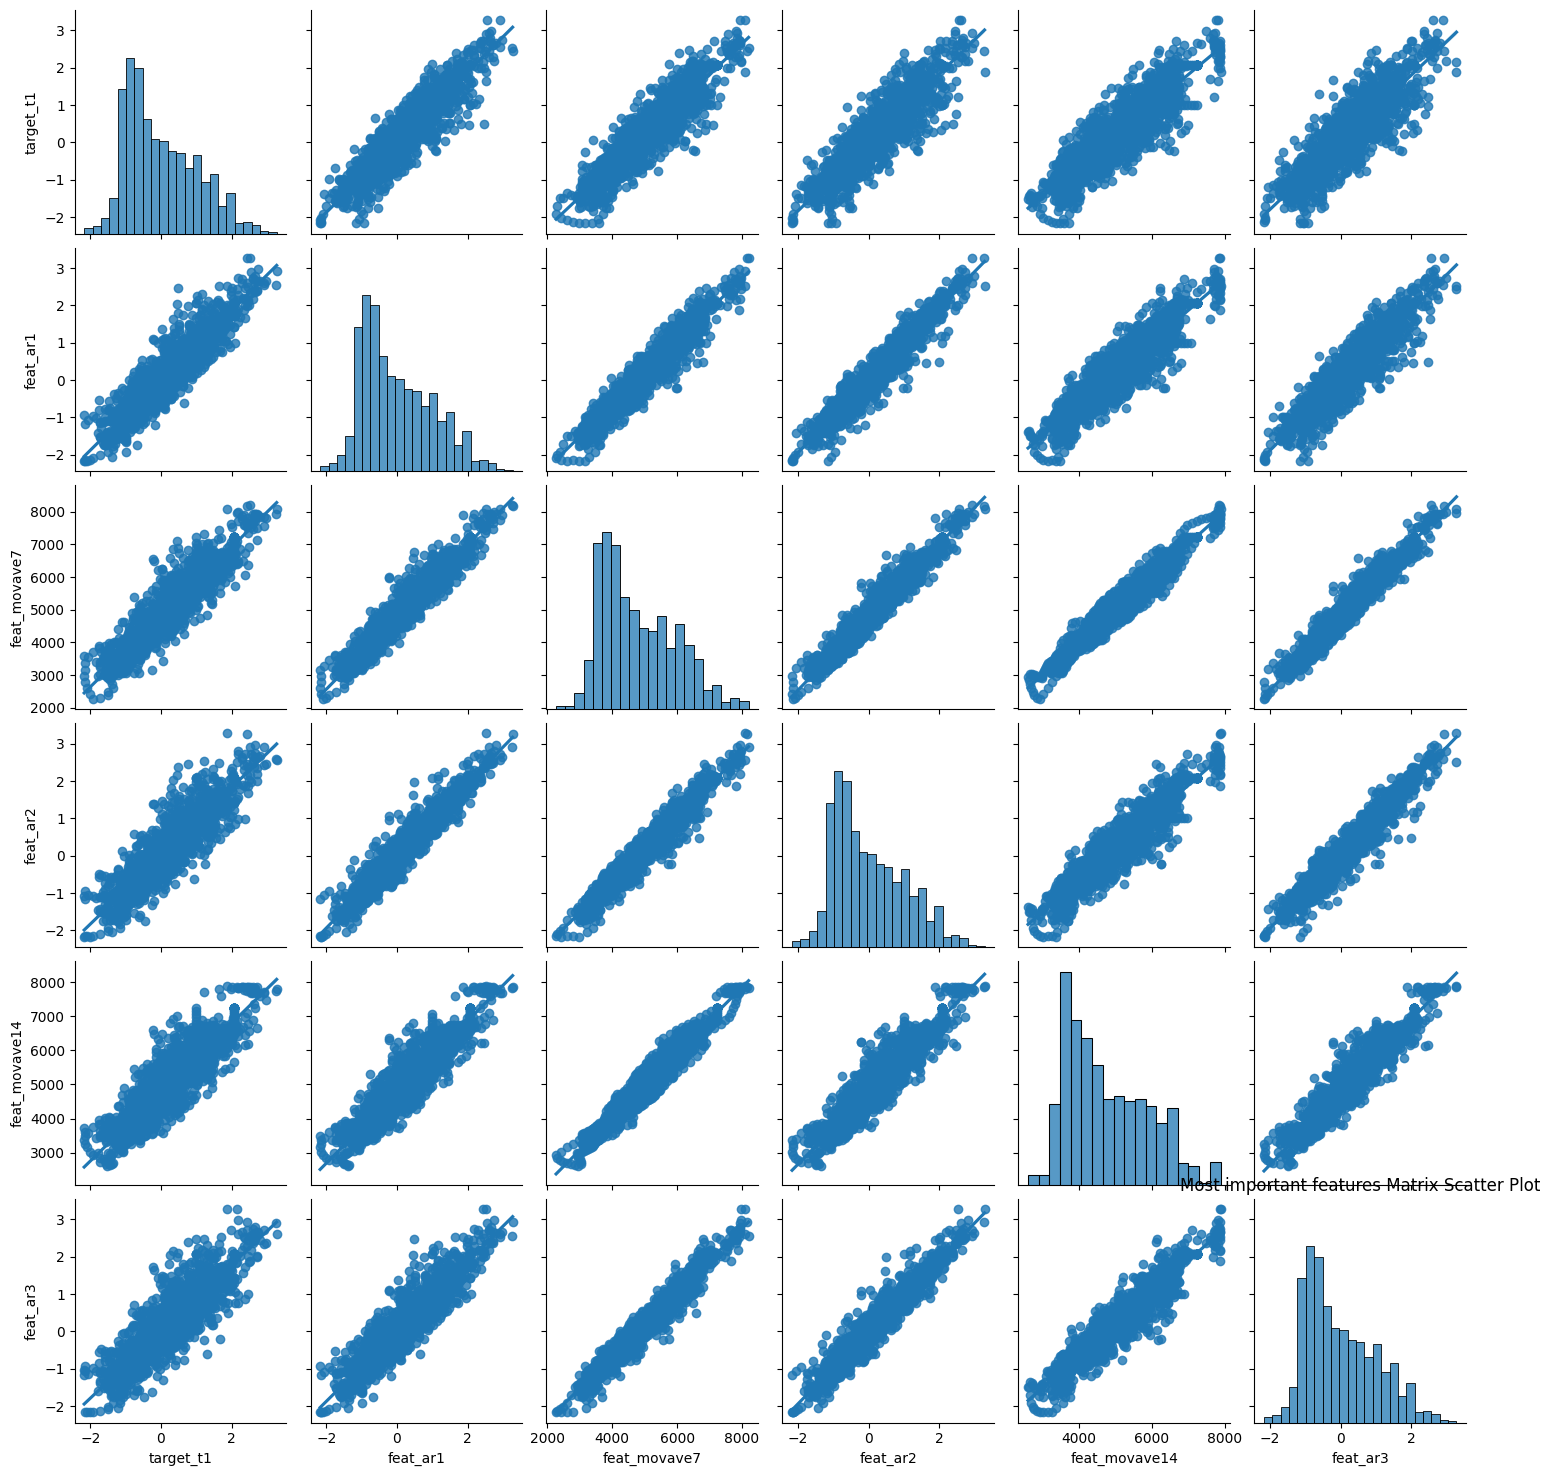

In [26]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

There are some features that are quite strongly linearly correlated with target, like AR_6 and MOVAVE_7, let's build some models and check this assumption

# Model Building
In this step, two candidates models are build using an nice feature in Scikit-Learn such us MultiOutput Regression, it provides a framework to automatically and easily fit models to predict several target variables.

First a baseline model (linear regression) will be fit and compared to a more advanced model, like Random Forest. A linear model does not need hyperparamenter tunning, and there is some correlation in data, so it is a strongh foundation, but there are several caveats:

- Target variable is not perfectly normally distributed with constant variance
- There are a lot of multicollinearity among predictors
- Observations are not independent

On the other hand an advanced model, like Random Forest, needs to perform hyperparamenter tunning, tipically it is solved by using GridSearch and Cross Validation, but time series data is not suitable to be used in CV, because data is shuffled in order to build k-folds. On the other hand, Scikit-Learng provide us with a nice solution: TimeSeries Splits, that respect time structure of date and iterativelly allow us to perform GridSearch

In [27]:
data_feateng = data[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  1848


### Split Data
Data points in 2023 are used as a holdout data to perform a honest assessment of model performance and carry out some residual analysis (6 months)

Total number of observations:  1848
Train: (1431, 59)(1431, 30), 
Test: (365, 59)(365, 30)


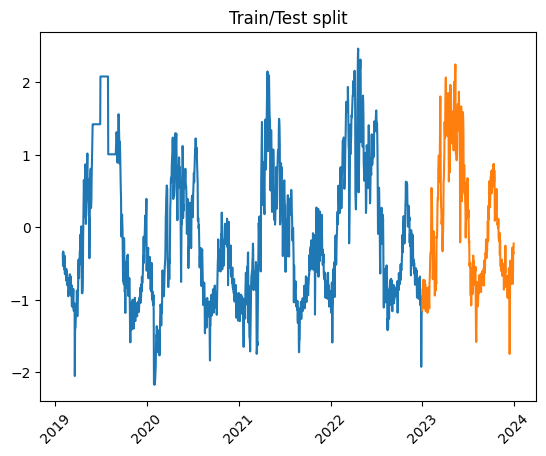

In [28]:
X_train = data_feateng.loc["2019":"2022"][features]
y_train = data_feateng.loc["2019":"2022"][targets]

X_test = data_feateng.loc["2023"][features]
y_test = data_feateng.loc["2023"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

### Baseline Model: Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.21821767688311117
Test RMSE: 0.23536449363900358


### Train a Random Forest with Time Series Split to tune Hyperparameters

In this example, TimeSeriesSplit framework is shown, on each fold, train data is closer to the beginning of forecasting period

TRAIN: 360 TEST: 357


C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


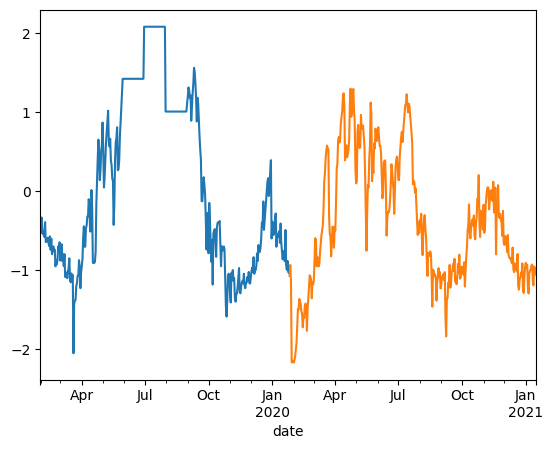

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()


TRAIN: 717 TEST: 357


C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


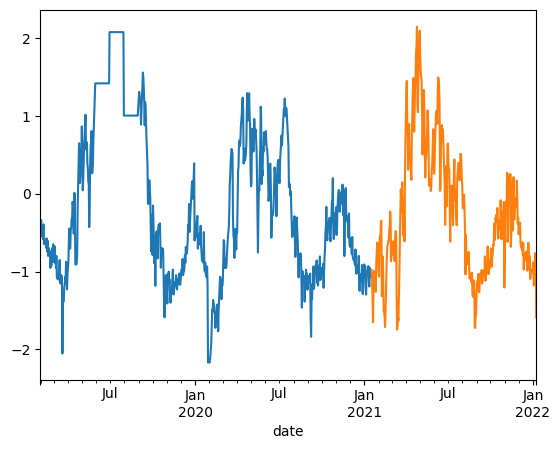

C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\sidra\AppData\Local\Temp\ipykernel_22028\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


TRAIN: 730 TEST: 357


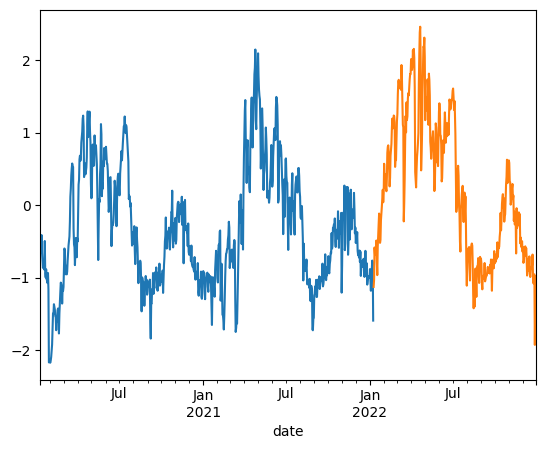

In [30]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()

In [31]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500],
        'max_depth': [3, 5, 10, 20, 30],
        'max_features': [4, 8, 16, 32, 59],
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []

        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)

        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")

    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 5}
Best-Fold Train RMSE:  0.019377761800384936
Best-Fold Val RMSE:  0.11103344515563887


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 3}
Best-Fold Train RMSE:  0.07135315941530887
Best-Fold Val RMSE:  0.12746532091998067


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 59, 'max_depth': 3}
Best-Fold Train RMSE:  0.08894365817084707
Best-Fold Val RMSE:  0.14041825343646336




In [32]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2021":"2022"], y_train.loc["2021":"2022", "target_t1"])

Using Random Forest provides an important improvement compared to Linear Regression. A word of caution, as RF are built bootstrapping data, so some time structure may be lost.

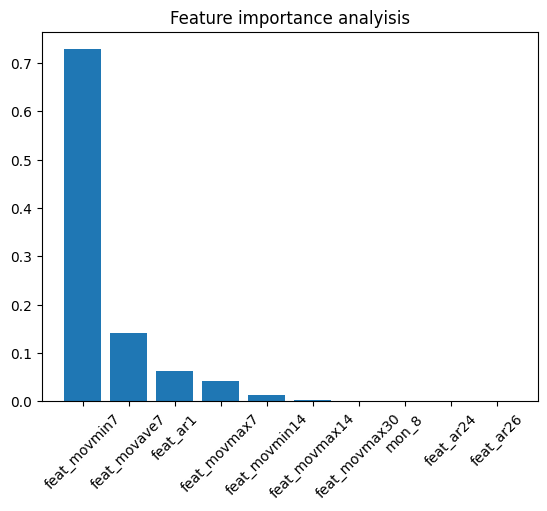

In [33]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

Results are not de same as the ones yielded by correlation analysis, showing that complex relationships and interactions may impact model performance. This is a very important point to take into consideration when working with models like ARIMA:

# Model Assessment:
### Performance Metrics: MAPE (Mean Absolute Percent Error)
Even though RMSE is a very common performance metric, MAPE is very suitable to use, and much easer to understand and communicate. Let's use one period ahead model to compute MAPE in test period

In [34]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [35]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  0.20911104856215704


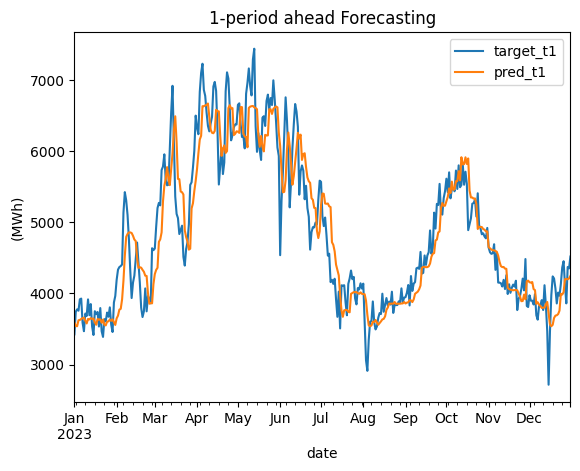

In [36]:
test_df[["target_t1", "pred_t1"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

MAPE is slightly over 10%, considering that electricity demand is highly dependend on weather, and February was exceptionally cold, it is an astonishing result. However, can it be improved?

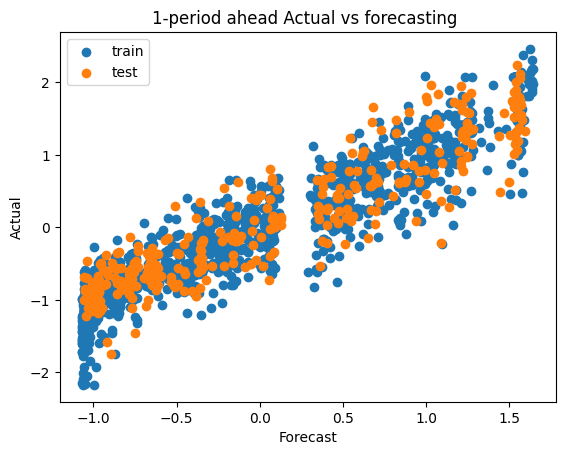

In [37]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

Plotting actual vs forecasted provides a glance on how good model can fit train data and generalize to test data

### Residual Analysis
In order to perform a comprehensive exercise, a residual analysis is carried out, in order to verify:

Is there some skewness in forecasting (tendendy to over or under forecast)?
Verify that residuals are normally distributed
Does outliers impact on performance? Is there any information remaining on residuals?
Residual over time
Plot Residual vs Actual

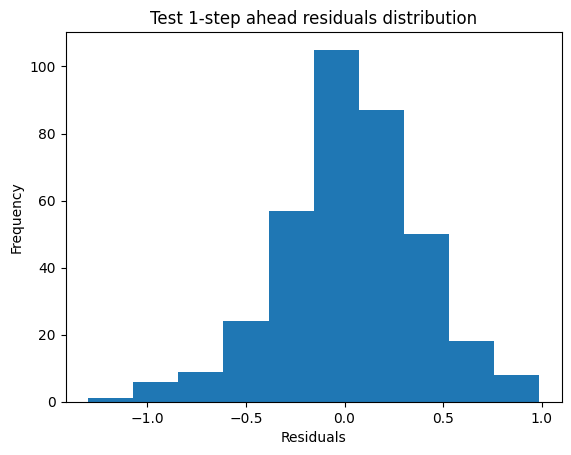

In [38]:
test_resid_1step.plot.hist(bins=10, title="Test 1-step ahead residuals distribution")
plt.xlabel("Residuals")
plt.show()

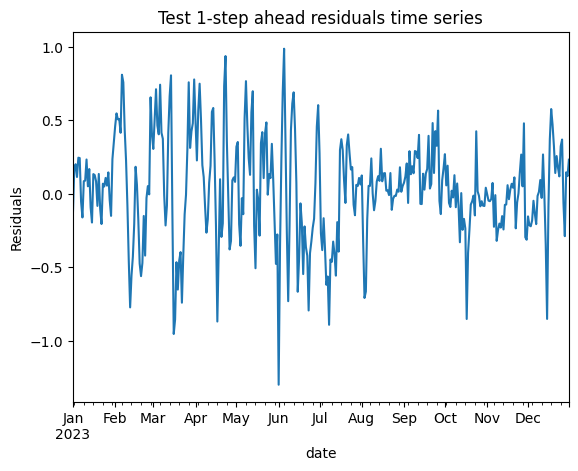

In [39]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.ylabel("Residuals")
plt.show()

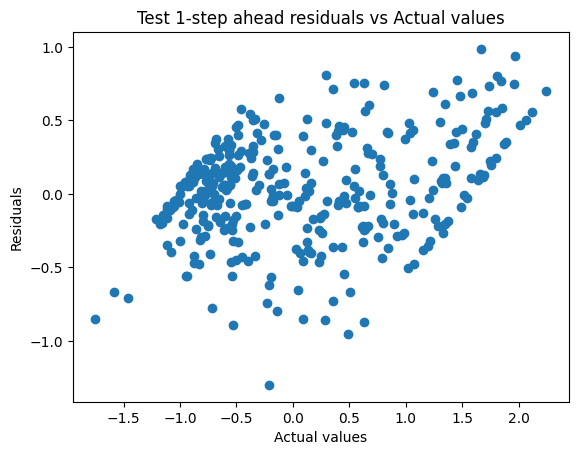

In [40]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.ylabel("Residuals")
plt.xlabel("Actual values")
plt.show()

# Forecasting
### Muti-period ahead model building
Once we know the best hiperparam set, a new instance of the RF model can be fit on the most recent (and relevant) data. Usually, it is considered that at least 2 years are needed in order to produce a long term daily forecast. Let's re-train a family of RF models using MultiOutput Regressor feature.

In [41]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2021":"2022"], y_train.loc["2021":"2022"])

In [42]:
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

### Performance Metrics: MAPE (Mean Absolute Percent Error)
Lastly, it is necesary to test forecasting accuracy in several periods, and assess whether it is stable.

In [43]:
periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)

print("MAPE test: ", test_MAPE)

MAPE test:  [np.float64(7.140000000000001), np.float64(9.84), np.float64(11.49), np.float64(13.700000000000001)]


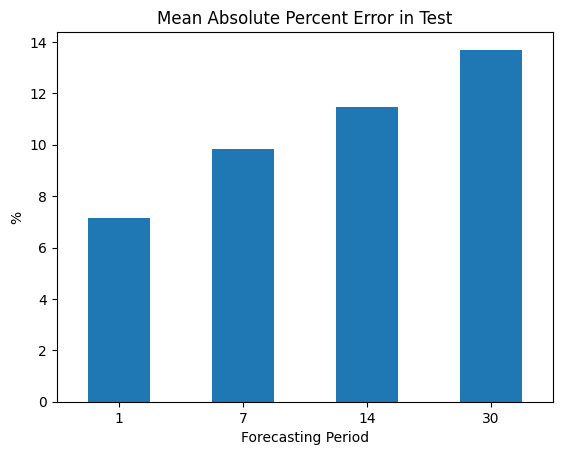

In [44]:
mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

Not surprisingly, forecasting accuacy on 1 period INCREASES, more data, not always is better. Moreover, MAPE increases with forecasting horizon, but it seems quite stable.

## Actual vs Forecasted
As previously stated, a quick way to assess model fit is to plot actual vs forecasted and take a glance at data scattering

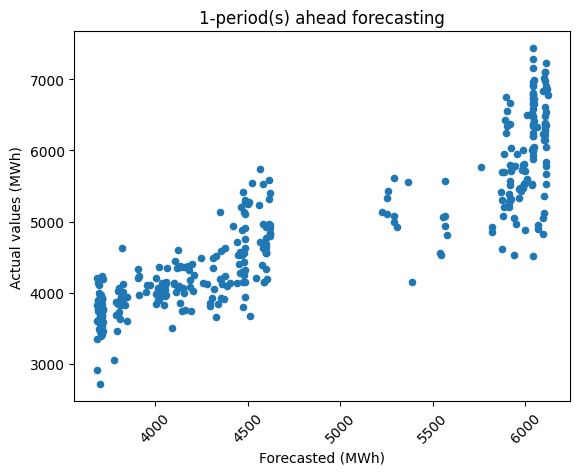

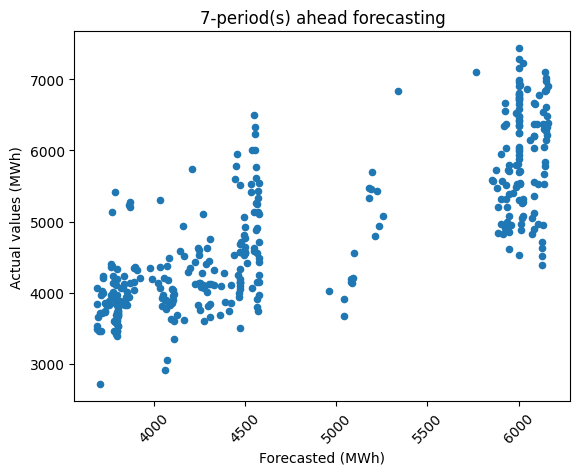

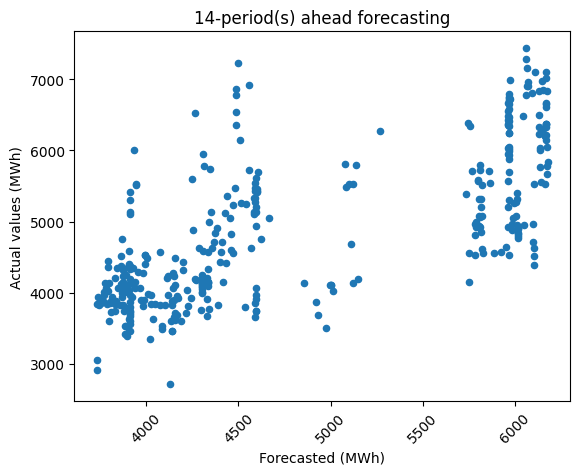

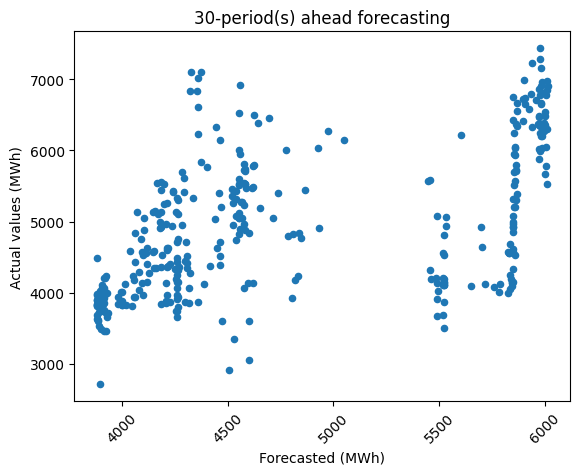

In [45]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("{}-period(s) ahead forecasting".format(t))
    plt.xlabel("Forecasted (MWh)")
    plt.ylabel("Actual values (MWh)")
    plt.xticks(rotation=45)
    plt.show()

It can be seen that, as forecasting period is longer, scattering is greater, specially for extreme values

## Forecasting 30-days ahead

In [46]:
test_df.index = test_df.index.date

In [47]:
forecast_range = pd.date_range(start=np.max(test_df.index.values), periods=tau, freq="D")
len(forecast_range)

30

In [53]:
forecast = []
for t in range(0, tau):
    #print(-(t+1), (t))
    forecast = p_test[-(t+1):,(t)]*std+mean
print(forecast)
with open('forecast.dill', 'wb') as f:
    dill.dump(forecast, f)

[4306.42971083 4319.71353487 4303.97566962 4306.44405936 4047.26975231
 4063.54621034 4039.82972019 4058.23700199 4060.31290589 4069.43679941
 4091.78917409 4094.76089916 4182.01644236 4105.33110812 4186.25602381
 4156.29427246 4185.7156701  4440.58339621 4716.26015405 4736.51804397
 4551.4192258  4539.23597339 4600.6942617  4550.40502531 4654.46724619
 4866.22866039 4927.05943824 4695.02282894 4641.50988612 4973.09815702]


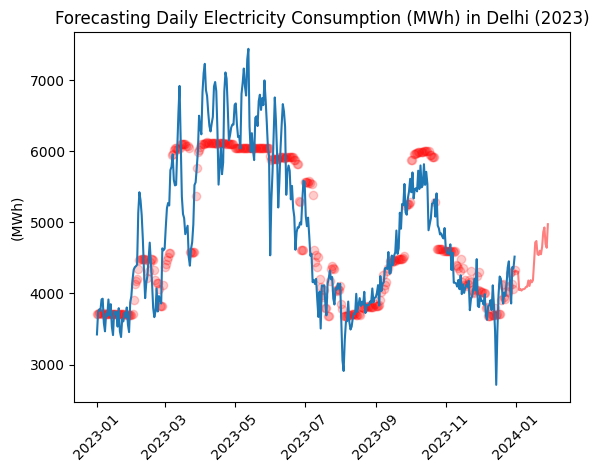

In [49]:
test_df["target_t1"].plot()
plt.scatter(x=test_df.index, y=test_df["pred_t1"], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range, forecast, c="r", alpha=0.5, label="forecasting")
plt.ylabel("(MWh)")
plt.xticks(rotation=45)
plt.title("Forecasting Daily Electricity Consumption (MWh) in Delhi (2023)")
plt.show()

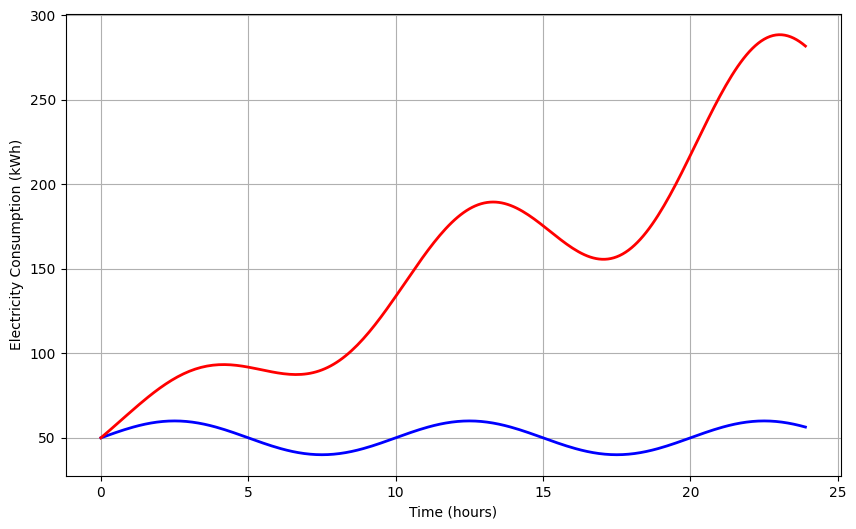

In [8]:

import numpy as np
import matplotlib.pyplot as plt

# Define time and electricity consumption data
time = np.arange(0, 24, 0.1)  # Time in hours (0 to 24 hours, with increments of 0.1 hour)
electricity = 50 + 10 * np.sin(0.2 * np.pi * time)  # Sample consumption data

# Simulate increasing frequency of electricity usage
freq_increase_factor = np.linspace(1, 5, len(time))  # Frequency increasing factor
electricity_adjusted = electricity * freq_increase_factor  # Adjust electricity data

# Plot the original and frequency-adjusted data
plt.figure(figsize=(10, 6))
plt.plot(time, electricity, 'b-', linewidth=2)  # Original electricity data
plt.plot(time, electricity_adjusted, 'r',linewidth=2)  # Frequency-increased data

# Add labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Electricity Consumption (kWh)')

# Show grid for better visualization
plt.grid(True)
plt.show()
